## Construcción de un modelo CNN con muy pocos datos
### Parte 2 - Entrenamiento con data augmentation

In [1]:
# de:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [1]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

Using TensorFlow backend.


In [3]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'small_data/train'
validation_data_dir = 'small_data/validation'

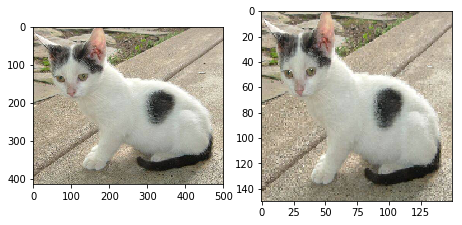

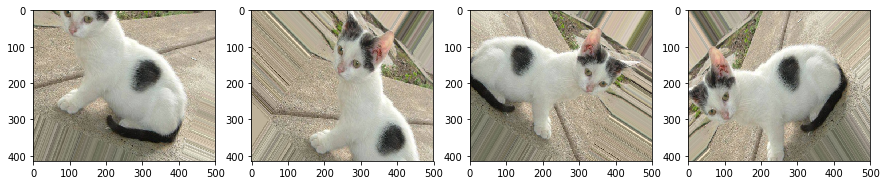

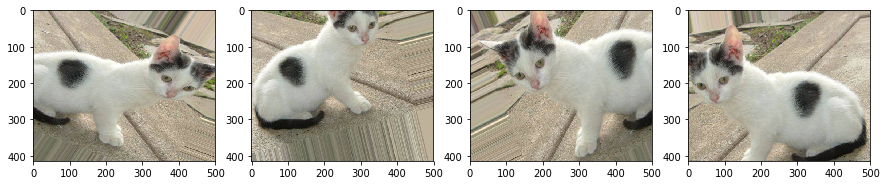

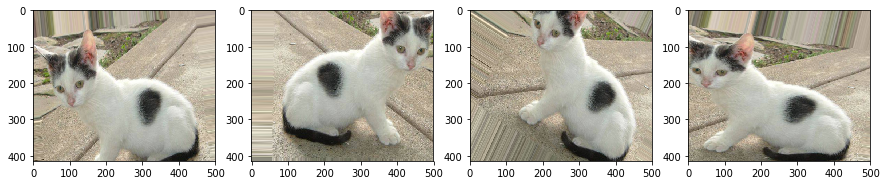

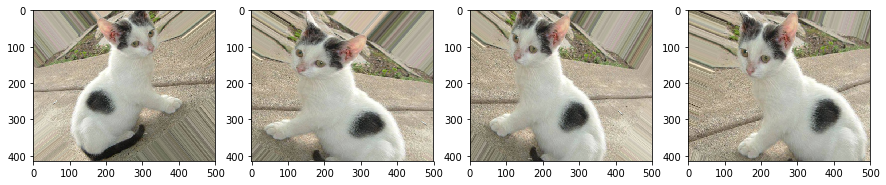

In [4]:
datagen = ImageDataGenerator(rescale=1. / 255,
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

if False:
    datagen = ImageDataGenerator(rescale=1. / 255,
                                 shear_range=.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

fichero = train_data_dir + '/cats/cat.3.jpg'
img = load_img(fichero)  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

if False:
    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir='preview',
                              save_prefix='cat',
                              save_format='jpeg'):
        i += 1
        if i > 20:
            break  # otherwise the generator would loop indefinitely
        else:
            i = 0
elif True:
    i = 0
    plt.figure(figsize=(7.5,4))
    plt.subplot(1,2,1)
    plt.imshow(x[0] / 255)
    plt.subplot(1,2,2)
#    plt.imshow(img_to_array(x[0],data_format=(150,150)))
    aux = load_img(fichero, target_size=(img_width, img_height))
    plt.imshow(aux)
    plt.show()
               
    for batch in datagen.flow(x, batch_size=1):
        if i % 4 == 0:
            if i >0:
                plt.show()
            plt.figure(figsize=(15,4))
        plt.subplot(1,4,1 + i%4)
        plt.imshow(batch[0])
        
        i += 1
        if i ==16:
            break  # otherwise the generator would loop indefinitely

In [ ]:
input_shape = (150,150,3)

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
# aqui empieza la red neuronal 'standard'
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
#              optimizer=optimizers.RMSprop(lr=1e-4),
              optimizer=optimizers.RMSprop(),
              metrics=['acc'])

In [ ]:
model.summary()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
batch_size = 16

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

In [ ]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_acc)), 100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.legend(['entrenamiento', 'validacion'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
aux = '_' + str(img_width) + 'x' + str(img_height) + '.npy'
print('leyendo mi_Xva'+aux+'...')
Xva = np.load('mi_Xva'+aux)

print('leyendo mi_yva.npy ...')
yva = np.load('mi_yva.npy')

print(Xva.shape)

In [ ]:
acum_tr_acc = []
acum_val_acc = []

In [ ]:
epochs = 30
nb_train_samples = 2000
#nb_validation_samples = 802

filepath="model_current_best_parte2.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs+1):
    if False:
        history = model.fit_generator(train_generator,
                                      steps_per_epoch=nb_train_samples // batch_size,
                                      epochs=1,
                                      callbacks=callbacks_list,
                                      verbose=1,
                                      validation_data=validation_generator,
                                      validation_steps=nb_validation_samples // batch_size)
    else:
        history = model.fit_generator(train_generator,
                                      steps_per_epoch=nb_train_samples // batch_size,
                                      epochs=1,
                                      callbacks=callbacks_list,
                                      verbose=1,
                                      validation_data=(Xva, yva))
    
    
    acum_tr_acc = acum_tr_acc + history.history['acc']
    acum_val_acc = acum_val_acc + history.history['val_acc']
    
    if len(acum_tr_acc) > 1:
        grafica_entrenamiento(acum_tr_acc, acum_val_acc)

model = load_model('model_current_best_parte2.h5')

#model.fit_generator(
#    train_generator,
#    steps_per_epoch=nb_train_samples // batch_size,
#    epochs=epochs,
#    validation_data=validation_generator,
#    validation_steps=nb_validation_samples // batch_size)

In [ ]:
model = load_model('model_current_best_parte2.h5')